I recently came accross this blog article ["Cities with Nice Weather"](https://jdonland.github.io/city_temperatures/index.html) by ***Jesse Onland***.

He explains his approach on how to find the best city, in terms of average and variance in temperature.

His analysis is excellent, well written and organized, but the data he used is far from being exhaustive. Indeed, the [list he got from Wikipedia](https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature) only shows temperature data for major cities, so he might be missing some his dream city, just because it's not populated enough...

Also, the list provides temperature data only, no information aboud wind speed and relative humidity, which are two important factors influcencing the perceived temperature.

We can do better 😎

In [46]:
%matplotlib inline
import warnings

import geopandas as gpd
import matplotlib
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry_convert as pc
import shapely
from adjustText import adjust_text
from geopandas import GeoDataFrame
from meteostat import Normals, Point
from tqdm.notebook import tqdm

Point.radius = 55_000  # Maximum radius for nearby stations in meters
# plt.style.use(["science", "notebook"])
plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 1)
plt.rcParams["figure.figsize"] = [20, 10]
pd.set_option("display.max_rows", None)

## Get Data for Cities Population

In [2]:
dataset_1 = pd.read_csv(r"./data/geonames-all-cities-with-a-population-1000.csv", sep=";", na_filter=False)
dataset_2 = pd.read_csv(r"./data/simplemaps_worldcities_basicv1.75.csv", sep=",", na_filter=False)
# We need to set na_filter=False since pandas will convert country code "NA" for Namibia as NaN...

In [3]:
dataset_1.head()

,Geoname ID,Name,ASCII Name,Alternate Names,Feature Class,Feature Code,Country Code,Country name EN,Country Code 2,Admin1 Code,Admin2 Code,Admin3 Code,Admin4 Code,population,Elevation,DIgital Elevation Model,Timezone,Modification date,LABEL EN,Coordinates
0,8396129,Sanjiang,Sanjiang,"Sanjiang,Sanjiang Jiedao,Sanjiang Qu,san jiang...",P,PPLA3,CN,China,,01,3402,,,0,,14,Asia/Shanghai,2021-09-19,China,"31.34813,118.36132"
1,8405692,Xinmin,Xinmin,"Xinmin,Xinmin Zhen,xin min,xin min zhen,新民,新民镇",P,PPLA4,CN,China,,33,8739734,,,28033,,402,Asia/Shanghai,2022-04-12,China,"30.39759,107.3895"
2,8416824,Jindaoxia,Jindaoxia,"Jindaoxia,Jindaoxia Zhen,jin dao xia,jin dao x...",P,PPLA4,CN,China,,33,8739734,,,13752,,323,Asia/Shanghai,2022-04-01,China,"30.00528,106.65187"
3,8420197,Jianlong,Jianlong,"Jianlong,Jianlong Xiang,jian long,jian long xi...",P,PPLA4,CN,China,,33,8739734,,,18151,,276,Asia/Shanghai,2022-04-01,China,"29.3586,106.18522"
4,8505210,Jianhua,Jianhua,"Bukui,Bukui Jiedao,Jianhua,Jianhua Qu,bo kui,b...",P,PPLA3,CN,China,,08,2302,,,0,,146,Asia/Shanghai,2022-03-12,China,"47.35773,123.95977"


In [4]:
dataset_1.drop(
    columns=[
        "Geoname ID",
        "Feature Class",
        "Feature Code",
        "Admin1 Code",
        "Admin2 Code",
        "Admin3 Code",
        "Admin4 Code",
        "Elevation",
        "DIgital Elevation Model",
        "Modification date",
    ],
    inplace=True,
)

In [5]:
dataset_1["Coordinates"] = dataset_1["Coordinates"].astype("string")
dataset_1[["lat", "lng"]] = dataset_1["Coordinates"].str.split(pat=",", n=1, expand=True)
dataset_1["lat"] = dataset_1["lat"].astype(float)
dataset_1["lng"] = dataset_1["lng"].astype(float)

In [6]:
dataset_1.query("`Country name EN` != ''", inplace=True)

In [7]:
dataset_2.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,primary,39105000,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,35362000,1360771077
2,Delhi,Delhi,28.6667,77.2167,India,IN,IND,Delhi,admin,31870000,1356872604
3,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23971000,1608618140
4,São Paulo,Sao Paulo,-23.5504,-46.6339,Brazil,BR,BRA,São Paulo,admin,22495000,1076532519


In [8]:
dataset_2.drop(columns=["capital", "id"], inplace=True)

In [9]:
dataset_2 = dataset_2[dataset_2["population"].str.isnumeric()]
dataset_2["population"] = dataset_2["population"].astype(int)

In [10]:
print(dataset_1.shape, dataset_2.shape)

(139571, 12) (42143, 9)


Let's check the data for a small city in UK:

In [11]:
dataset_1.query("`Country Code` == 'GB' and Name == 'Portsmouth'")

,Name,ASCII Name,Alternate Names,Country Code,Country name EN,Country Code 2,population,Timezone,LABEL EN,Coordinates,lat,lng
66901,Portsmouth,Portsmouth,"Porchemue,Porchémue,Portsmouth,Portsmut,Portsm...",GB,United Kingdom,,194150,Europe/London,United Kingdom,"50.79899,-1.09125",50.79899,-1.09125


In [12]:
dataset_2.query("`country` == 'United Kingdom' and city == 'Portsmouth'")

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,population
2407,Portsmouth,Portsmouth,50.8058,-1.0872,United Kingdom,GB,GBR,Portsmouth,248440


Seems accurate!

Let's see for Tokyo:

In [13]:
dataset_1.query("`Country Code` == 'JP' and Name == 'Tokyo'")

,Name,ASCII Name,Alternate Names,Country Code,Country name EN,Country Code 2,population,Timezone,LABEL EN,Coordinates,lat,lng
33145,Tokyo,Tokyo,"Edo,TYO,Tochiu,Tocio,Tokija,Tokijas,Tokio,Toki...",JP,Japan,,8336599,Asia/Tokyo,Japan,"35.6895,139.69171",35.6895,139.69171


In [14]:
dataset_2.query("`country` == 'Japan' and city == 'Tokyo'")

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,population
0,Tokyo,Tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,39105000


As you can see, there's a huge difference in terms of population size.

Looks like the `dataset_1` considers the 23 wards that made up the boundaries of the historic city of Tokyo, while `dataset_2` considers the greater Tokyo metropolitan area, which is spread over 3 prefectures...

Manila, capital city of the Philippines:

In [15]:
dataset_1.query("`Country Code` == 'PH' and Name == 'Manila'")

,Name,ASCII Name,Alternate Names,Country Code,Country name EN,Country Code 2,population,Timezone,LABEL EN,Coordinates,lat,lng
16765,Manila,Manila,"City of Manila,Dakbayan sa Manila,Lungsod ng M...",PH,Philippines,,1600000,Asia/Manila,Philippines,"14.6042,120.9822",14.6042,120.9822


In [16]:
dataset_2.query("`country` == 'Philippines' and city == 'Manila'")

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,population
3,Manila,Manila,14.6,120.9833,Philippines,PH,PHL,Manila,23971000


Same issue: `dataset_1` considers the Manila city, while `dataset_2` gives data for the larger urban area of Metro Manila.

In [17]:
dataset_1.query("`Country Code` == 'SG' and Name == 'Singapore'")

,Name,ASCII Name,Alternate Names,Country Code,Country name EN,Country Code 2,population,Timezone,LABEL EN,Coordinates,lat,lng
9440,Singapore,Singapore,"SIN,Sin-ka-po,Singapore,Singapore City,Singapo...",SG,Singapore,,3547809,Asia/Singapore,Singapore,"1.28967,103.85007",1.28967,103.85007


In [18]:
dataset_2.query("`country` == 'Singapore'")

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,population
135,Singapore,Singapore,1.3,103.8,Singapore,SG,SGP,Central Singapore,5271000


Both dataset seem outdated since Singapore current population is 6M, for both the country and the city.

Some data visualization would help to see if some cities/countries/continents are missing:

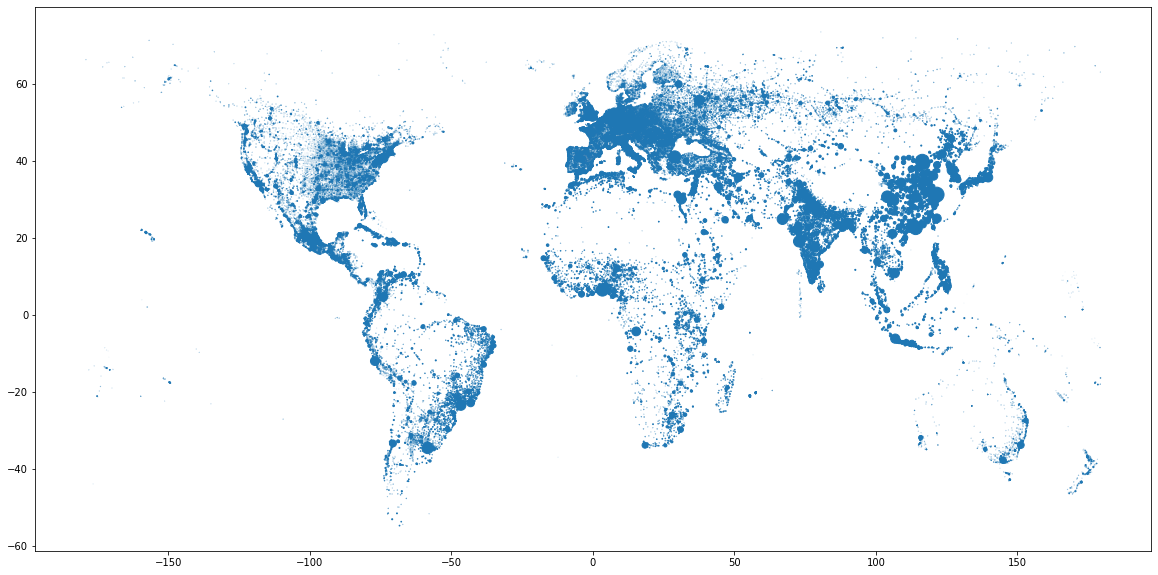

In [19]:
plt.scatter(x=dataset_1["lng"], y=dataset_1["lat"], s=dataset_1["population"] / 1e5)
plt.show()

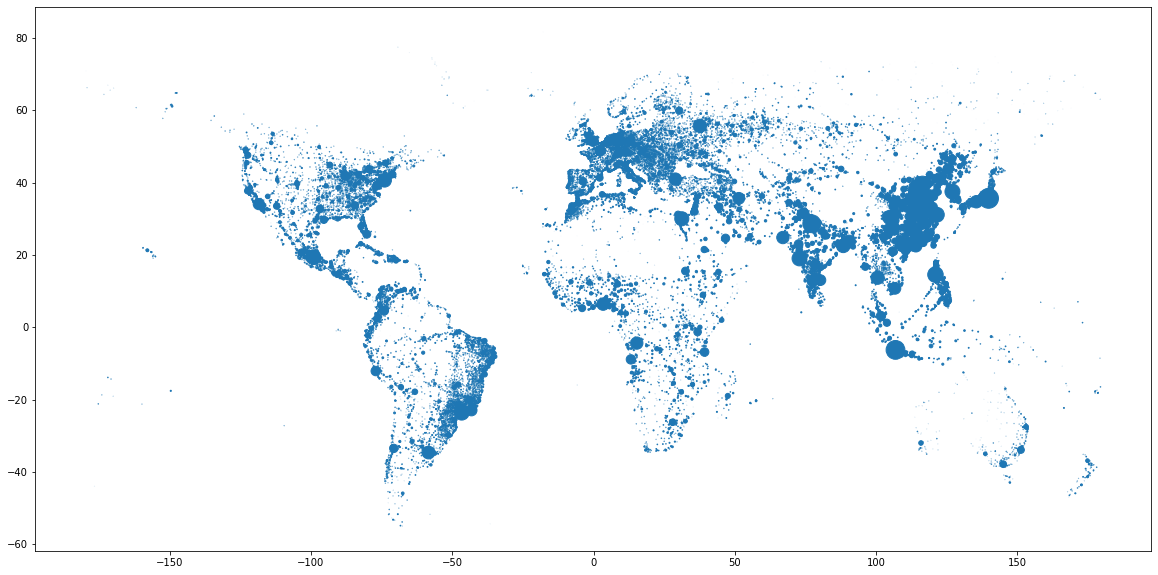

In [20]:
plt.scatter(x=dataset_2["lng"], y=dataset_2["lat"], s=dataset_2["population"] / 1e5)
plt.show()

People sure like living near the sea!

Since both dataset seem accurate enouth, from now on we'll just keep the first dataset.

In [21]:
df = dataset_1
print(df.shape)
df.head()

(139571, 12)


,Name,ASCII Name,Alternate Names,Country Code,Country name EN,Country Code 2,population,Timezone,LABEL EN,Coordinates,lat,lng
0,Sanjiang,Sanjiang,"Sanjiang,Sanjiang Jiedao,Sanjiang Qu,san jiang...",CN,China,,0,Asia/Shanghai,China,"31.34813,118.36132",31.34813,118.36132
1,Xinmin,Xinmin,"Xinmin,Xinmin Zhen,xin min,xin min zhen,新民,新民镇",CN,China,,28033,Asia/Shanghai,China,"30.39759,107.3895",30.39759,107.38950
2,Jindaoxia,Jindaoxia,"Jindaoxia,Jindaoxia Zhen,jin dao xia,jin dao x...",CN,China,,13752,Asia/Shanghai,China,"30.00528,106.65187",30.00528,106.65187
3,Jianlong,Jianlong,"Jianlong,Jianlong Xiang,jian long,jian long xi...",CN,China,,18151,Asia/Shanghai,China,"29.3586,106.18522",29.35860,106.18522
4,Jianhua,Jianhua,"Bukui,Bukui Jiedao,Jianhua,Jianhua Qu,bo kui,b...",CN,China,,0,Asia/Shanghai,China,"47.35773,123.95977",47.35773,123.95977


In [22]:
df["Country Code"] = df["Country Code"].astype("string")
df.query("`Country Code` != 'TL'", inplace=True)  # Remove Timor-Leste, not supported by pycountry
df.query("`Country Code` != 'EH'", inplace=True)  # Remove Western Sahara, not supported by pycountry
df["Continent Code"] = df.apply(lambda row: pc.country_alpha2_to_continent_code(row["Country Code"]), axis=1)

In [23]:
print(df.shape)
df["Continent Code"].value_counts()

(139552, 13)


EU    69029
NA    29755
AS    24765
SA     6701
AF     4889
OC     4413
Name: Continent Code, dtype: int64

## Get Historial Weather Data

We now need some historical weather data.

As explained earlier, we can't use [this list](https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature) since it only contains data for "big" cities.

We need historical weather data of the last decade for all the cities shortlisted.

Only monthly statistics are needed since temperatures don't change significantly within a month. We'll compute the variance in temperature of a city only from the statistical monthly weather data.

[OpenWeather](https://openweathermap.org/) provides an API with [statistical monthly weather data](https://openweathermap.org/api/statistics-api#month) (temp, humidity, wind, etc.) for any month of the entire year, but it's way too expensive for us.

For now, we'll use [Meteostat](https://dev.meteostat.net/), an open platform which provides free access to historical weather and climate data. Unfortunately, it lacks information about wind speed or humidity for some cities.

In [24]:
tokyo = Point(lat=35.6839, lon=139.7744)
data = Normals(tokyo, 1991, 2020).fetch()
data

,tavg,tmin,tmax,prcp,wspd,pres,tsun
month,,,,,,,
1,6.3,2.6,10.0,59.8,NaN,1015.9,NaN
2,7.0,3.1,10.8,56.6,NaN,1015.9,NaN
3,10.0,5.9,14.0,116.6,NaN,1015.1,NaN
4,14.8,10.7,19.0,134.1,NaN,1013.9,NaN
5,19.6,15.7,23.5,139.9,NaN,1011.9,NaN
6,22.8,19.5,26.0,168.0,NaN,1009.0,NaN
7,26.7,23.4,30.0,156.5,NaN,1008.6,NaN
8,28.1,24.7,31.5,154.7,NaN,1010.2,NaN
9,24.4,21.2,27.6,222.4,NaN,1013.0,NaN


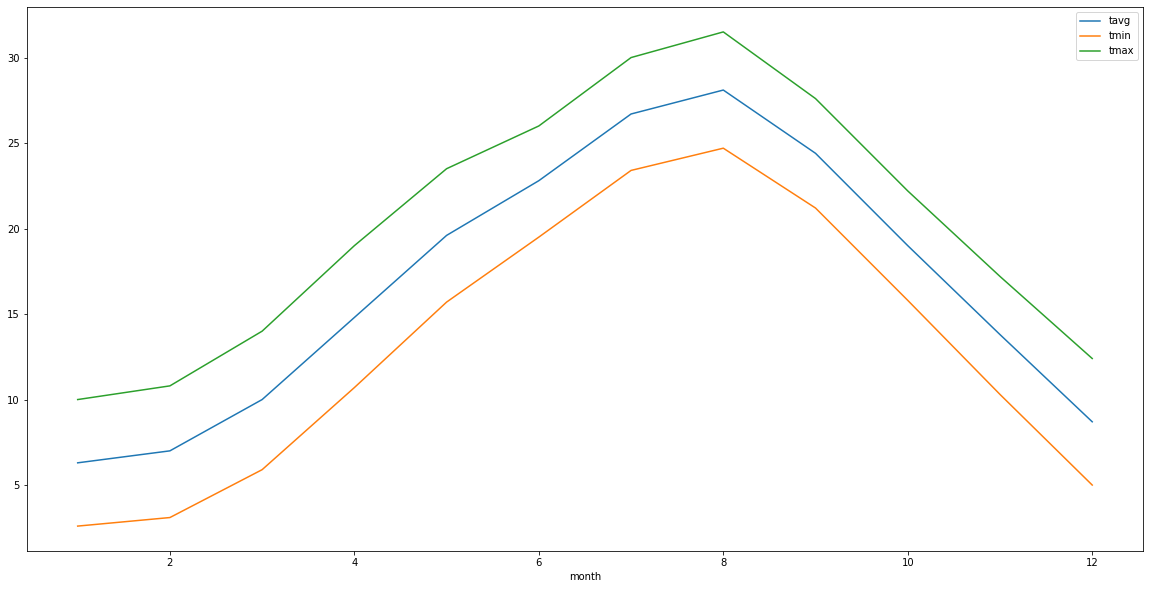

In [25]:
data.plot(y=["tavg", "tmin", "tmax"])
plt.show()

Pretty big temperature variations over the year for Tokyo!

Having lived there for a few weeks, the `tmax` data is closer to ~~the~~ my perceived temperature than the `tavg`.

In [26]:
def get_mean_std_temperature_for_loc(lat: float, lon: float) -> tuple[float, float]:
    pt = Point(lat=lat, lon=lon)
    try:
        with warnings.catch_warnings():  # disable some meteostat warnings
            warnings.simplefilter("ignore")
            data = Normals(pt, 1991, 2020).fetch()
    except pd.errors.ParserError:  # escape some meteostat bugs
        return np.nan, np.nan, np.nan, np.nan
    mean_ = data["tmax"].mean()
    std_ = data["tmax"].std()
    tmax_ = data["tmax"].max()
    range_ = data["tmax"].max() - data["tmax"].min()
    return mean_, std_, tmax_, range_

Gathering weather data for 140,000 cities takes some time. We keep the biggest cities:

In [27]:
dataset_1.query("population >= 100000", inplace=True)
dataset_2.query("population >= 100000", inplace=True)

In [28]:
Tmean = []
Tstd = []
Tmax = []
Trange = []
for row in tqdm(df.itertuples(), total=df.shape[0]):
    mean_, std_, tmax_, range_ = get_mean_std_temperature_for_loc(row.lat, row.lng)
    Tmean.append(mean_)
    Tstd.append(std_)
    Tmax.append(tmax_)
    Trange.append(range_)
df["Tmean"] = Tmean
df["Tstd"] = Tstd
df["Tmax"] = Tmax
df["Trange"] = Trange

  0%|          | 0/4684 [00:00<?, ?it/s]

In [29]:
df.dropna(subset=["Tmean", "Tstd", "Tmax"], inplace=True)

## Summmary Statistics

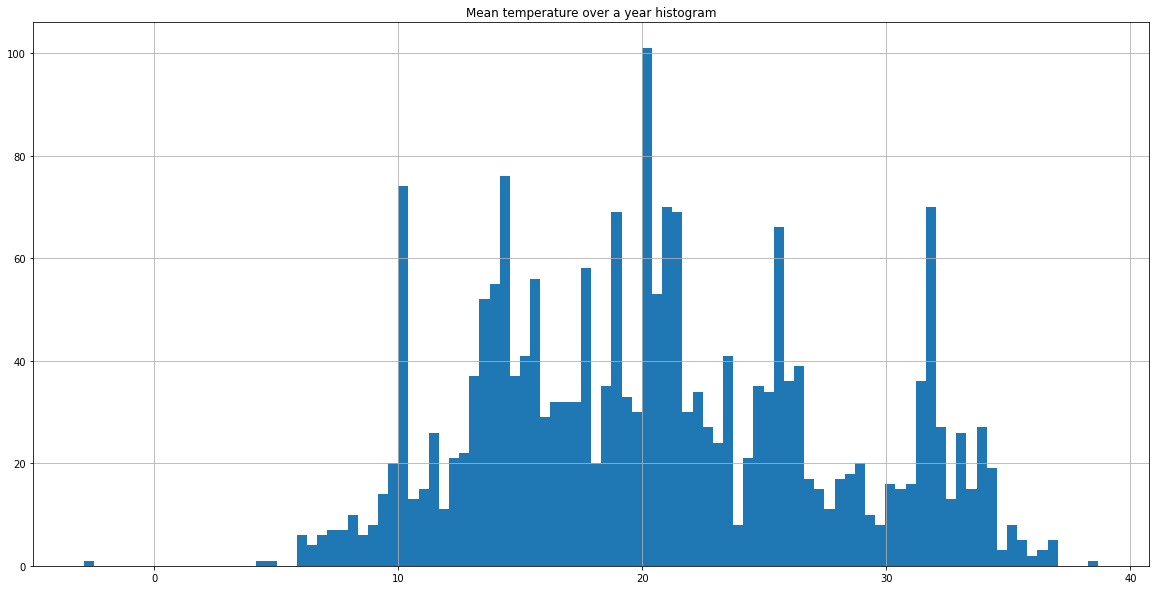

In [30]:
df["Tmean"].hist(bins=100)
plt.title("Mean temperature over a year histogram");

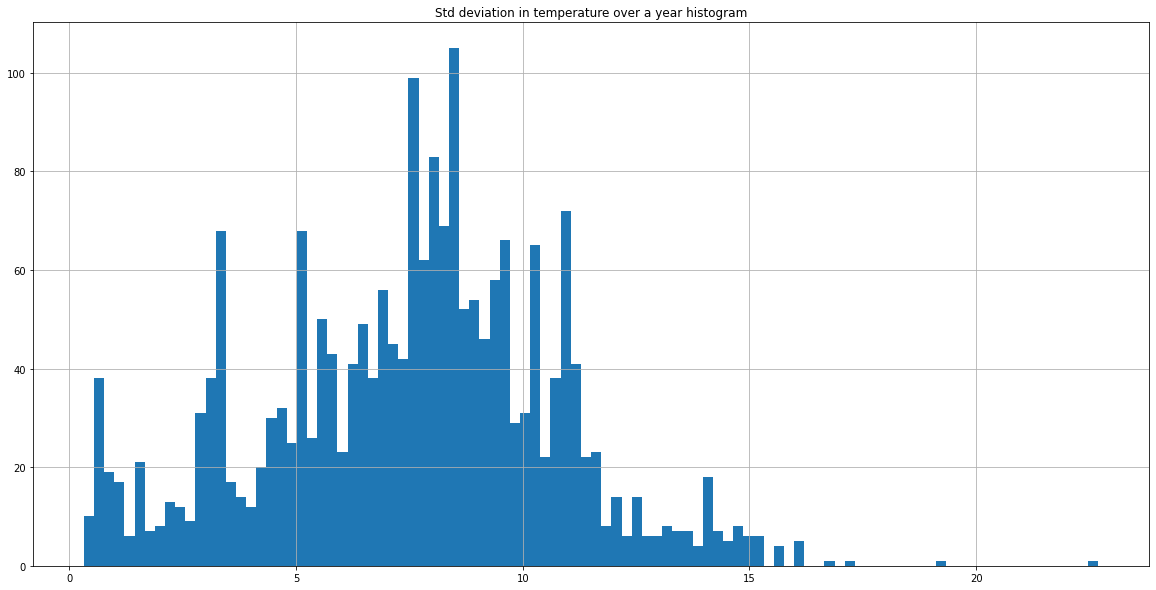

In [31]:
df["Tstd"].hist(bins=100)
plt.title("Std deviation in temperature over a year histogram");

Get the extreme values in temperature:

In [32]:
df.query("Tmean == Tmean.max() or Tmean == Tmean.min()")

,Name,ASCII Name,Alternate Names,Country Code,Country name EN,Country Code 2,population,Timezone,LABEL EN,Coordinates,lat,lng,Continent Code,Tmean,Tstd,Tmax,Trange
37323,Mecca,Mecca,"A Meca,La Meca,La Mecca,La Mecque,Macoraba,Mae...",SA,Saudi Arabia,,1323624,Asia/Riyadh,Saudi Arabia,"21.42664,39.82563",21.42664,39.82563,AS,38.683333,4.705864,43.9,12.6
49692,Yakutsk,Yakutsk,"D'okuuskaj,Jakutsk,YKS,Yakutsk,Yerkutsk,yakuch...",RU,Russian Federation,RU,235600,Asia/Yakutsk,Russian Federation,"62.03389,129.73306",62.03389,129.73306,EU,-2.883333,22.694887,25.8,60.2


Cities with the most stable/unstable temperatures over a year:

In [33]:
df.query("Tstd == Tstd.min() or Tstd == Tstd.max()").sort_values(by=["Tstd"])

,Name,ASCII Name,Alternate Names,Country Code,Country name EN,Country Code 2,population,Timezone,LABEL EN,Coordinates,lat,lng,Continent Code,Tmean,Tstd,Tmax,Trange
122628,Jayapura,Jayapura,"DJJ,Djajapoera,Djajapura,Dzajapura,Dzhajapura,...",ID,Indonesia,,134895,Asia/Jayapura,Indonesia,"-2.53371,140.71813",-2.53371,140.71813,AS,32.241667,0.317543,32.8,1.2
49692,Yakutsk,Yakutsk,"D'okuuskaj,Jakutsk,YKS,Yakutsk,Yerkutsk,yakuch...",RU,Russian Federation,RU,235600,Asia/Yakutsk,Russian Federation,"62.03389,129.73306",62.03389,129.73306,EU,-2.883333,22.694887,25.8,60.2


In [34]:
cities_to_plot = [
    df.query("`ASCII Name` == 'Reykjavik' and `Country name EN` == 'Iceland'"),
    df.query("`ASCII Name` == 'Yakutsk' and `Country name EN` == 'Russian Federation'"),
    df.query("`ASCII Name` == 'Edinburgh' and `Country name EN` == 'United Kingdom'"),
    df.query("`ASCII Name` == 'Paris' and `Country name EN` == 'France'"),
    df.query("`ASCII Name` == 'Tokyo' and `Country name EN` == 'Japan'"),
    df.query("`ASCII Name` == 'Toronto' and `Country name EN` == 'Canada'"),
    df.query("`ASCII Name` == 'Singapore' and `Country name EN` == 'Singapore'"),
]
assert all(not city.empty for city in cities_to_plot)

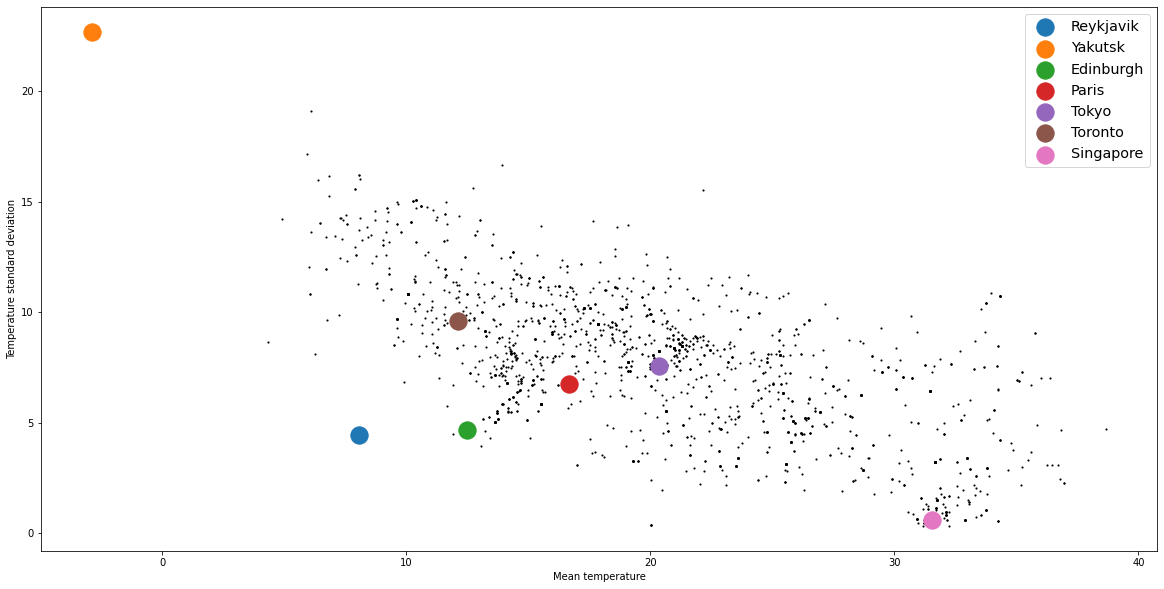

In [35]:
plt.scatter(df["Tmean"], df["Tstd"], s=5, c="k", marker=".")
plt.xlabel("Mean temperature")
plt.ylabel("Temperature standard deviation")
for city in cities_to_plot:
    plt.scatter(city["Tmean"].iloc[0], city["Tstd"].iloc[0], s=300, label=city["ASCII Name"].iloc[0])
plt.legend(fontsize="x-large")
plt.show()

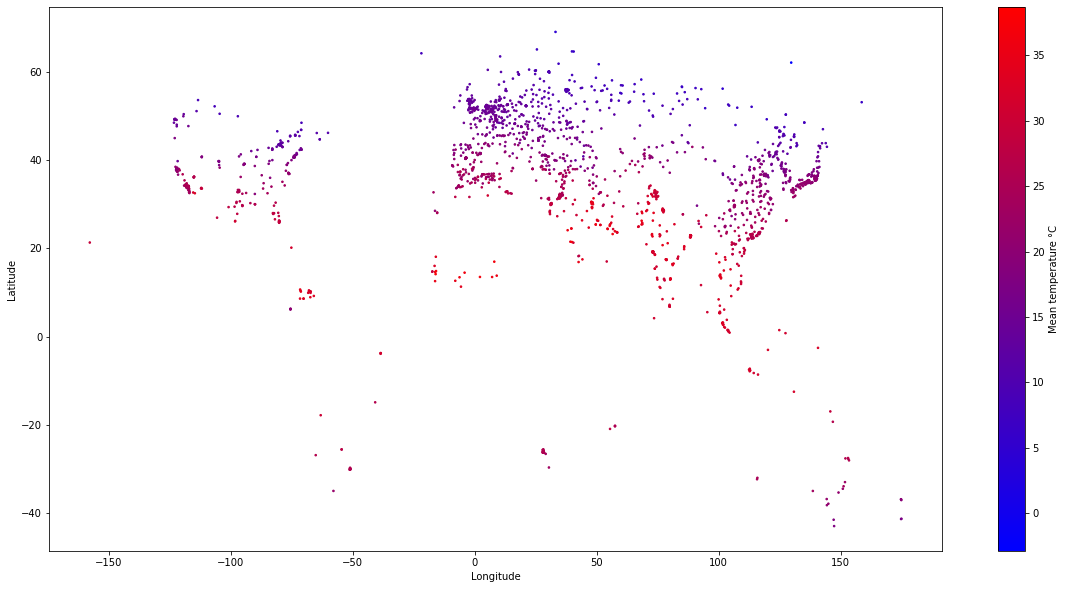

In [36]:
cm_cold_hot = mcol.LinearSegmentedColormap.from_list("cold_hot", ["b", "r"])
sc = plt.scatter(x=df["lng"], y=df["lat"], c=df["Tmean"], s=10, marker=".", cmap=cm_cold_hot)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(sc, label="Mean temperature °C")
plt.show()

Seems like many cities in Africa and South America disappeared for lack of data.

## So Which Cities Are the "Best"?

*Disclaimer: everything below is based only on my personal preferences...*

All cities warmer than my hometown are rejected, too warm in summer!

In [37]:
threshold_city = df.query("`ASCII Name` == 'Limoges' and `Country name EN` == 'France'")
df.query(
    "Tmean <= @threshold_city.Tmean.iloc[0] and Tstd <= @threshold_city.Tstd.iloc[0] and Trange <= @threshold_city.Trange.iloc[0] and Tmax <= @threshold_city.Tmax.iloc[0]",
    inplace=True,
)

In [38]:
print(df.shape)
df.groupby(["Continent Code"])["Country name EN"].value_counts()

(96, 17)


Continent Code  Country name EN
EU              United Kingdom     65
                Netherlands         9
                France              6
                Belgium             2
                Ireland             2
                Iceland             1
                Norway              1
NA              Canada              8
                United States       2
Name: Country name EN, dtype: int64

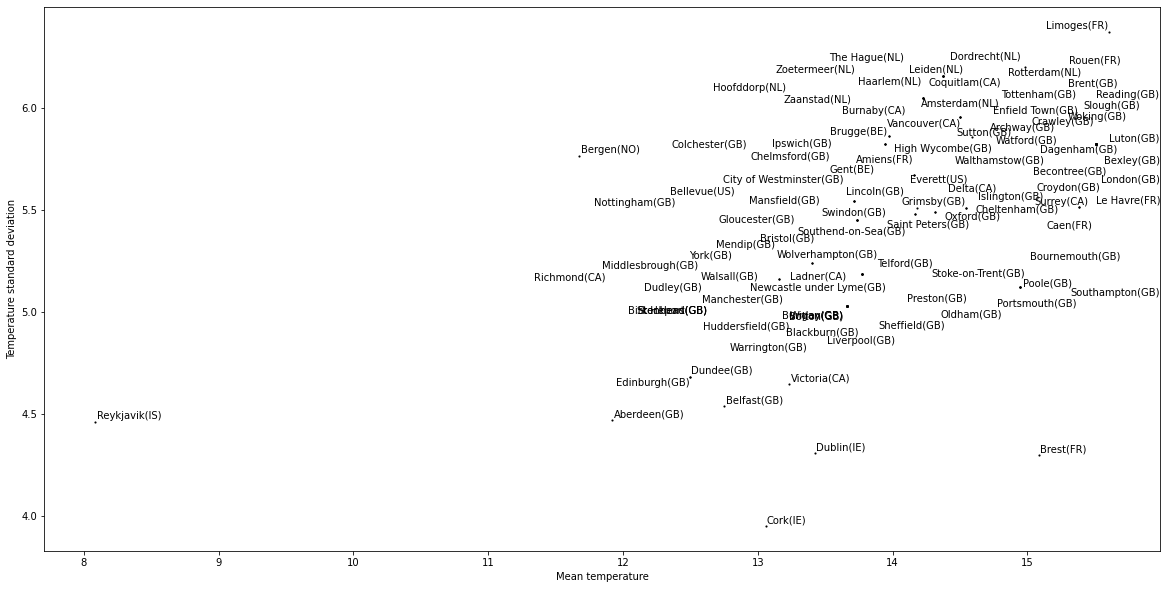

In [39]:
fig, ax = plt.subplots()
ax.scatter(df["Tmean"], df["Tstd"], s=5, c="k", marker=".")
plt.xlabel("Mean temperature")
plt.ylabel("Temperature standard deviation")

texts = [
    plt.text(
        df["Tmean"].iloc[i],
        df["Tstd"].iloc[i],
        f'{df["ASCII Name"].iloc[i]}({df["Country Code"].iloc[i]})',
        fontsize=10,
        ha="center",
        va="center",
    )
    for i in range(len(df))
]
adjust_text(texts)
plt.show()

In [41]:
df_europe = df.query("`Continent Code` == 'EU'")

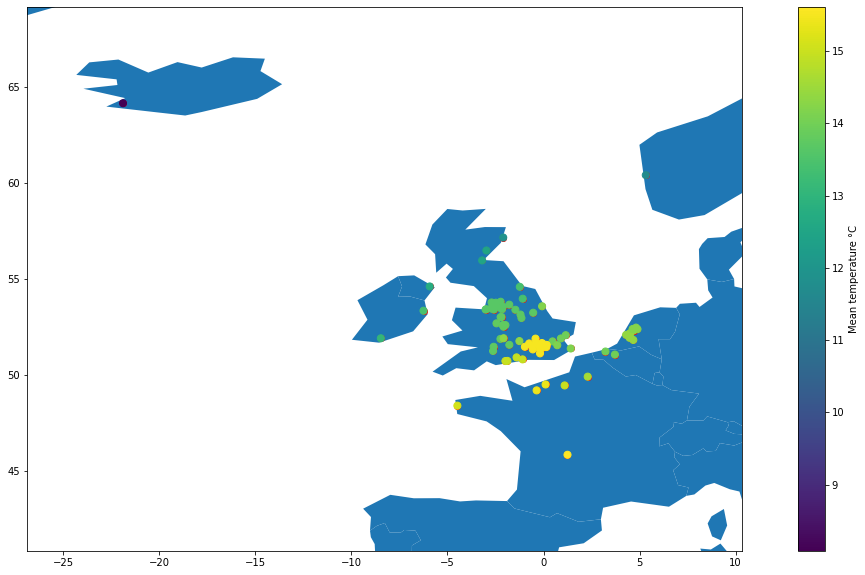

In [69]:
geometry = [shapely.geometry.Point(x, y) for x, y in zip(df_europe["lng"], df_europe["lat"])]
gdf = GeoDataFrame(df_europe, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
gdf.plot(ax=world.plot(), marker="o", color="red")
sc = plt.scatter(x=df["lng"], y=df["lat"], c=df["Tmean"], s=50, marker="o", cmap="viridis")
plt.xlim(df_europe["lng"].min() - 5, df_europe["lng"].max() + 5)
plt.ylim(df_europe["lat"].min() - 5, df_europe["lat"].max() + 5)
plt.colorbar(sc, label="Mean temperature °C")
plt.show()